In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
# Python
from pathlib import Path
import os
import warnings
import math
import datetime
import time
warnings.filterwarnings('ignore')

# TORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.resnet import resnet18

# MISC
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from dotted_dict import DottedDict
import pickle

from BTwins.utils import calc_lambda
from BTwins.barlow import *
from BTwins.transform_utils import *
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer
from Beta.models import get_projector
import eval_utils
import plot_utils

# TODO
- same augmentation setting as in baselines
- search over csg splits
    - content: 0.1 -> 0.9
    - style: 0.1 -> 0.9 of (1 - content)


In [4]:
config = {
    'device': 'cuda',
    'cuda_visible_devices': '0',
    'p_data': '/mnt/data/csprites/single_csprites_64x64_n7_c24_a32_p13_s3_bg_inf_random_function_77000',
    'target_variable': 'shape',
    'batch_size': 1024,
    'num_workers': 24,
    'num_epochs': 100,
    'freqs': {
        'ckpt': 50,         # epochs
        'linprob': 5,       # epochs
    },
    'num_vis': 64,
    'backbone': "FCN16i223o64",
    'backbone_args': {
        'ch_last': 128,
        'dim_in': 3,
    },
    'dim_out': 64,
    'optimizer': 'adam',
    'optimizer_args': {
        'lr': 0.001,
        'weight_decay': 1e-6
    },
    'projector': [512,
                  512,
                  512],
    'ratio_cnt': 0.2,
    'ratio_stl_geo': 0.5,
    'w_off': 40,
    'p_ckpts': "ckpts",
    'p_model': "model_{}.ckpt",
    'p_mask_on': "mask_on.png",
    'p_mask_off': "mask_off.png",
    'p_cc_train': "cc_train.png",
    'p_stats': "stats.pkl",
    'p_config': 'config.pkl',
    'p_R_train': 'R_train.npy',
    'p_R_valid': 'R_valid.npy',
    'p_Y_valid': 'Y_valid.npy',
    'p_Y_train': 'Y_train.npy',
}
p_base = Path("/mnt/experiments/csprites") / Path(config["p_data"]).name / "tmp"
#
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
#
config["p_experiment"] = str(p_base / "BT_[{}_d{}]_[S3]_{}".format(
    config["backbone"],
    config["backbone_args"]["ch_last"],
    st
    )
                            )
config = DottedDict(config)
pprint.pprint(config)

{'backbone': 'FCN16i223o64',
 'backbone_args': DottedDict({'ch_last': 128, 'dim_in': 3}),
 'batch_size': 1024,
 'cuda_visible_devices': '0',
 'device': 'cuda',
 'dim_out': 64,
 'freqs': DottedDict({'ckpt': 50, 'linprob': 5}),
 'num_epochs': 100,
 'num_vis': 64,
 'num_workers': 24,
 'optimizer': 'adam',
 'optimizer_args': DottedDict({'lr': 0.001, 'weight_decay': 1e-06}),
 'p_R_train': 'R_train.npy',
 'p_R_valid': 'R_valid.npy',
 'p_Y_train': 'Y_train.npy',
 'p_Y_valid': 'Y_valid.npy',
 'p_cc_train': 'cc_train.png',
 'p_ckpts': 'ckpts',
 'p_config': 'config.pkl',
 'p_data': '/mnt/data/csprites/single_csprites_64x64_n7_c24_a32_p13_s3_bg_inf_random_function_77000',
 'p_experiment': '/mnt/experiments/csprites/single_csprites_64x64_n7_c24_a32_p13_s3_bg_inf_random_function_77000/tmp/BT_[FCN16i223o64_d128]_[S3]_2021-09-15_13-07-17',
 'p_mask_off': 'mask_off.png',
 'p_mask_on': 'mask_on.png',
 'p_model': 'model_{}.ckpt',
 'p_stats': 'stats.pkl',
 'projector': [512, 512, 512],
 'ratio_cnt': 0.2,

In [5]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = config.cuda_visible_devices
device = torch.device(config.device)

# Data

In [6]:
p_ds_config = Path(config.p_data) / "config.pkl"

with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)

target_variable = config.target_variable
target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
n_classes = ds_config["n_classes"][target_variable]

In [7]:
norm_transform = utils.normalize_transform(
    ds_config["means"],
    ds_config["stds"])
inverse_norm_transform = utils.inverse_normalize_transform(
    ds_config["means"],
    ds_config["stds"]
)
target_transform = lambda x: x[target_idx]
#
init_transform = lambda x: x
stl_transform = transforms.Compose([
                transforms.RandomApply(
                    [transforms.ColorJitter(
                        brightness=(0.6, 1.4),
                        contrast=(0.8, 1.2),
                        saturation=(0.7, 1.3),
                        hue=(-0.5, 0.5))],
                    p=1.0
                ),
                #transforms.RandomGrayscale(p=0.1),
                GaussianBlur(p=0.3),
                Solarization(p=0.4)
])

geo_transform = transforms.Compose([
    transforms.RandomResizedCrop(ds_config["img_size"],
                                 scale=(0.4, 1.9),
                                 ratio=(0.75, 1.333),
                                 interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=1),
                transforms.RandomVerticalFlip(p=1)
])

fin_transform = transforms.Compose([
                transforms.ToTensor(),
                norm_transform
            ])

train_transform = CSpritesTripleTransform(
    init_transform = init_transform,
    stl_transform=stl_transform,
    geo_transform=geo_transform,
    fin_transform=fin_transform
)

transform_linprob = transforms.Compose([
                transforms.Resize(ds_config["img_size"]),
                transforms.ToTensor(),
                norm_transform
            ])

In [8]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=train_transform,
    target_transform=target_transform,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_linprob_train = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=target_transform,
    split="train"
)
dl_linprob_train = DataLoader(
    ds_linprob_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)
ds_linprob_valid = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=target_transform,
    split="valid"
)
dl_linprob_valid = DataLoader(
    ds_linprob_valid,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)
print(len(dl_train))
print(len(dl_linprob_train))
print(len(dl_linprob_valid))

68
69
7


# Visualize Data

In [9]:
n_vis = 16

In [10]:
# dl_train
(x_ori, x_stl, x_geo),_ = next(iter(dl_train))
#
x_ori = inverse_norm_transform(x_ori[:n_vis])
x_stl = inverse_norm_transform(x_stl[:n_vis])
x_geo = inverse_norm_transform(x_geo[:n_vis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


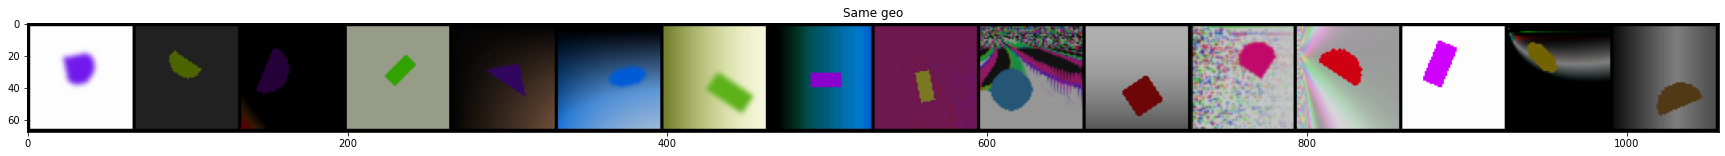

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


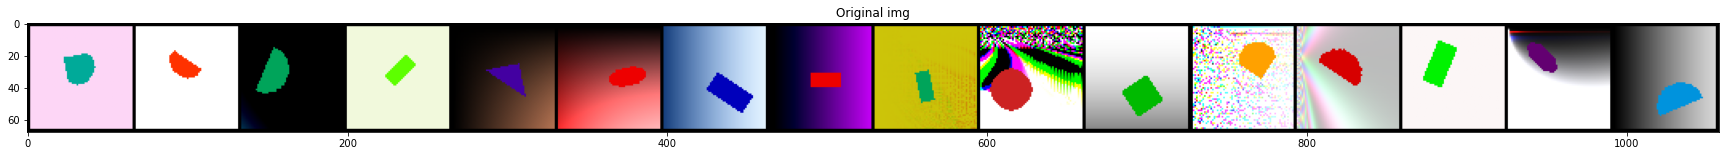

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


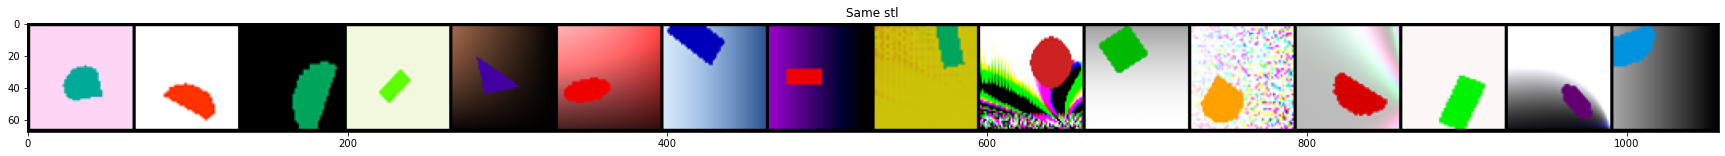

In [11]:
grid_img = torchvision.utils.make_grid(x_geo, nrow=n_vis)
plt.figure(figsize=(n_vis * 2, 2))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Same geo")
plt.show()

grid_img = torchvision.utils.make_grid(x_ori, nrow=n_vis)
plt.figure(figsize=(n_vis * 2, 2))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Original img")
plt.show()
#
grid_img = torchvision.utils.make_grid(x_stl, nrow=n_vis)
plt.figure(figsize=(n_vis * 2, 2))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Same stl")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['ellipse', 'pyramid', 'ellipse', 'rectangle', 'moon', 'moon', 'pyramid', 'gelato', 'gelato', 'ellipse', 'moon', 'square', 'gelato', 'gelato', 'square', 'square']


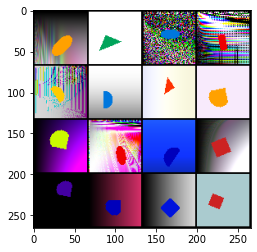

In [12]:
# dl_linprob_train
x,y = next(iter(dl_linprob_train))
x = x[:n_vis]
y = y[:n_vis]
#
x = inverse_norm_transform(x)
#
grid_img = torchvision.utils.make_grid(x, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
#
y = [ds_config["class_maps"]["shape"][idx.item()] for idx in y]
print(y)

# Model

In [13]:
class BarlowTwins(nn.Module):
    def __init__(self, backbone, projector):
        super().__init__()
        self.backbone = backbone
        self.projector = projector
        
        self.bn = nn.BatchNorm1d(projector.dim_out * 3, affine=False)
        #self.bn_cnt = nn.BatchNorm1d(dim_cnt + dim_geo, affine=False)
        #self.bn_geo = nn.BatchNorm1d(dim_geo, affine=False)
        #self.bn_stl = nn.BatchNorm1d(dim_stl, affine=False)

    def get_representation(self, x):
        return self.backbone(x)

    def forward(self, x):
        return self.projector(self.backbone(x))

In [14]:
# backbone
backbone = get_backbone(config.backbone, **config.backbone_args)

# barlow projector
barlow_projector = get_projector(planes_in=backbone.dim_out, sizes=config.projector)

ratio_cnt = config["ratio_cnt"]
ratio_stl_geo = config["ratio_stl_geo"]
#
dim_cnt = int(ratio_cnt * barlow_projector.dim_out)
dim_stl_geo = barlow_projector.dim_out - dim_cnt
dim_stl = int(ratio_stl_geo * dim_stl_geo)
dim_geo = dim_stl_geo - dim_stl
dim_tot = dim_stl + dim_geo + dim_cnt
assert dim_tot == barlow_projector.dim_out
#
print("DIMS: stl: {} cnt: {} geo: {}, sum={}".format(dim_stl, dim_cnt, dim_geo, dim_tot))
model = BarlowTwins(backbone, barlow_projector)
#
if torch.cuda.device_count() > 1 and device != "cpu":
    print("Using {} gpus!".format(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model)
    model.backbone = model.module.backbone
elif device != "cpu":
    print("Using 1 GPU!")
else:
    print("Using CPU!")
model = model.to(device)

DIMS: stl: 205 cnt: 102 geo: 205, sum=512
Using 1 GPU!


In [15]:
optimizer = get_optimizer(config.optimizer, model.parameters(), config.optimizer_args)

In [16]:
stats = {
    'train': {
        'loss': [],
        'epoch': [],
    },
    'linprob': {
        'linacc': [],
        'knnacc': [],
        'epoch': [],
    }
}
stats = DottedDict(stats)
#
p_experiment = Path(config.p_experiment)
p_experiment.mkdir(exist_ok=True, parents=True)
p_ckpts = p_experiment / config.p_ckpts
p_ckpts.mkdir(exist_ok=True)

In [17]:
def create_masks(dim_cnt, dim_stl, dim_geo):
    dim = dim_cnt + dim_stl + dim_geo
    #
    stl_start = 0
    stl_end = dim
    #
    ori_start = dim
    ori_end = dim + dim
    #
    geo_start = dim + dim
    geo_end = dim + dim + dim
    #
    n_total = (dim*3)**2
    n_ones_on_diag = dim * 3
    n_ones_off_diag = (3*dim_cnt + 1*dim_stl + 1*dim_geo) * 2
    n_zeros = n_total - n_ones_on_diag - n_ones_off_diag

    # create on diag mask
    mask = torch.zeros((dim*3, dim*3))
    #
    # diagonal entries
    # stl-ori
    d_stl_ori = torch.diagonal(
        mask[stl_start: stl_start + dim_stl + dim_cnt,
             ori_start: ori_start + dim_stl + dim_cnt
    ])
    d_stl_ori += 1

    d_stl_geo = torch.diagonal(
        mask[stl_start + dim_stl: stl_start + dim_stl + dim_cnt,
             geo_start + dim_stl: geo_start + dim_stl + dim_cnt

    ])
    d_stl_geo += 1
    d_ori_geo = torch.diagonal(
          mask[ori_start + dim_stl: ori_end,
               geo_start + dim_stl: geo_end
              ]
    )
    d_ori_geo += 1
    mask = mask + mask.T
    on_diag_mask = mask > 0
    #

    off_diag_mask = 1 - mask
    off_diag_mask_diag = torch.diagonal(off_diag_mask)
    off_diag_mask_diag -= 1
    off_diag_mask = off_diag_mask > 0
    #
    assert on_diag_mask.sum().item() == n_ones_off_diag
    assert off_diag_mask.sum().item() == n_zeros
    
    return on_diag_mask, off_diag_mask

In [18]:
on_diag_mask, off_diag_mask = create_masks(dim_cnt, dim_stl, dim_geo)
w_off = (on_diag_mask.sum() / off_diag_mask.sum()) * config["w_off"]
#
ratio_on_off = on_diag_mask.sum() / off_diag_mask.sum()

print("#on_diag_mask:  ", on_diag_mask.sum())
print("#off_diag_mask: ", off_diag_mask.sum())
print("#on/#off:       ", ratio_on_off)
print("w_off", w_off)
print(w_off)

#on_diag_mask:   tensor(1432)
#off_diag_mask:  tensor(2356328)
#on/#off:        tensor(0.0006)
w_off tensor(0.0243)
tensor(0.0243)


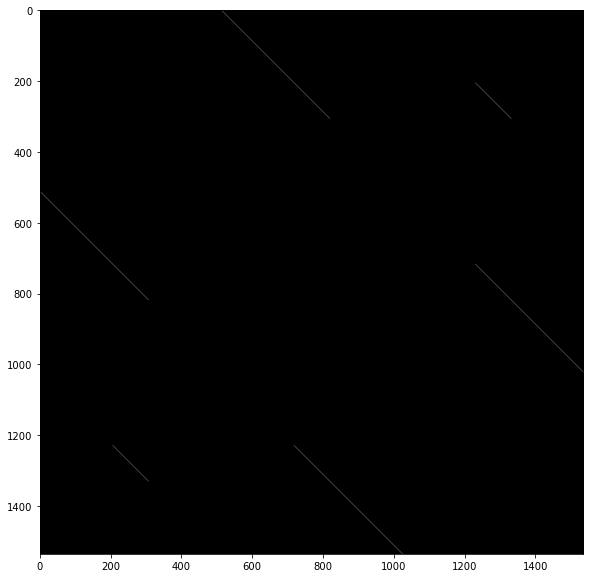

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(on_diag_mask.cpu().numpy(), cmap="gray")
plt.savefig(p_experiment / config["p_mask_on"])
plt.show()

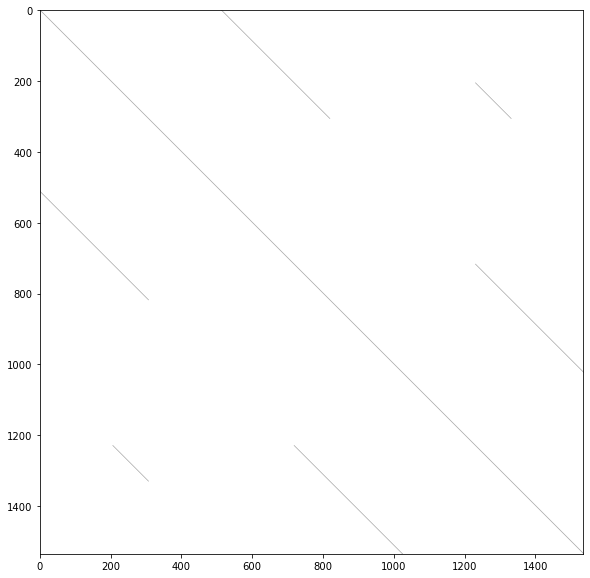

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(off_diag_mask.cpu().numpy(), cmap="gray")
plt.savefig(p_experiment / config["p_mask_off"])
plt.show()

In [ ]:
on_diag_mask = on_diag_mask.to(device)
off_diag_mask = off_diag_mask.to(device)
#
global_step = 0
for epoch_idx in range(1, config.num_epochs + 1, 1):
    ################
    # TRAIN
    ################
    model.train()
    epoch_step = 0
    epoch_loss = 0
   
    desc = "[{:3}/{:3}]".format(epoch_idx, config.num_epochs)
    pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{n_fmt}/{total_fmt}{postfix}')
    #
    for (x_ori, x_stl, x_geo), _ in pbar:
        x_ori = x_ori.to(device)
        x_stl = x_stl.to(device)
        x_geo = x_geo.to(device)

        for param in model.parameters():
            param.grad = None
        
        # PROJECT
        z_ori = model(x_ori)
        z_stl = model(x_stl)
        z_geo = model(x_geo)
        
        z = torch.cat([z_stl, z_ori, z_geo], dim=1)
        z = model.bn(z)
        c = z.T @ z
        c.div_(z.shape[0])
        
        on_diag_items = torch.masked_select(c, on_diag_mask)
        off_diag_items = torch.masked_select(c, off_diag_mask)
        
        on_diag_loss = on_diag_items.add_(-1).pow_(2).sum()
        off_diag_loss = off_diag_items.pow_(2).sum()
        
        loss = on_diag_loss + w_off * off_diag_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_step += 1
        global_step += 1
        #
        pbar.set_postfix({
            'L': loss.item(),
            "on": on_diag_loss.item(),
            'off': (off_diag_loss * w_off).item(),
            'off_raw': off_diag_loss.item()
        })

    stats.train.loss.append(epoch_loss / epoch_step)
    stats.train.epoch.append(epoch_idx)

    ################
    # Linprob
    ################
    if epoch_idx % config.freqs.linprob == 0 or epoch_idx == config.num_epochs:
        model.eval()
        linacc, knnacc = utils.linprob_model(model.backbone, dl_linprob_valid, device)
        print("    Linprob Eval @LR: {:.2f} @KNN: {:.2f}".format(linacc, knnacc))
        stats.linprob.epoch.append(epoch_idx)
        stats.linprob.knnacc.append(knnacc)
        stats.linprob.linacc.append(linacc)
        model.train()
    # Checkpoint
    if epoch_idx % config.freqs.ckpt == 0 or epoch_idx == config.num_epochs:
        print("save model!")
        if torch.cuda.device_count() > 1 and device != "cpu":
            torch.save(model.module.state_dict(), p_ckpts / config.p_model.format(epoch_idx))
        else:
            torch.save(model.state_dict(), p_ckpts / config.p_model.format(epoch_idx))

In [ ]:
cc  = np.copy(c.detach().cpu().numpy())
plt.figure(figsize=(10, 10))
plt.imshow(cc, cmap="gray")
plt.colorbar()
plt.savefig(p_experiment / config["p_cc_train"])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(on_diag_mask.cpu().numpy(), cmap="gray")
plt.savefig(p_experiment / config["p_mask_on"])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(off_diag_mask.cpu().numpy(), cmap="gray")
plt.savefig(p_experiment / config["p_mask_off"])
plt.show()

# Plot 

In [ ]:
# plot losses
plt.plot(stats.train.epoch, stats.train.loss, label="train")
plt.legend()
plt.savefig(p_experiment / "barlow_loss.png")
plt.show()

# plot linprob acc
plt.plot(stats.linprob.epoch, stats.linprob.knnacc, label="knn")
plt.plot(stats.linprob.epoch, stats.linprob.linacc, label="lin")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1])
plt.legend()
plt.savefig(p_experiment / "linprob_acc.png")
plt.show()

# Save stats and config

In [ ]:
with open(p_experiment / config.p_config, "wb") as file:
    pickle.dump(config, file)
with open(p_experiment / config.p_stats, "wb") as file:
    pickle.dump(stats, file)

# Get Representations 

In [ ]:
dl_train, dl_valid = utils.get_raw_csprites_dataloader(
    p_data=config.p_data,
    img_size = ds_config["img_size"],
    batch_size = config.batch_size,
    norm_transform=norm_transform,
    num_workers = config["num_workers"]
)
p_R_train = p_experiment / config["p_R_train"]
p_Y_train = p_experiment / config["p_Y_train"]
p_R_valid = p_experiment / config["p_R_valid"]
p_Y_valid = p_experiment / config["p_Y_valid"]
#
model.eval()
R_train, Y_train = utils.get_representations(model.backbone, dl_train, device, imgs=False)
R_valid, Y_valid, X_valid = utils.get_representations(model.backbone, dl_valid, device, imgs=True, inverse_norm_transform=inverse_norm_transform)
#
np.save(p_R_train, R_train)
np.save(p_Y_train, Y_train)
np.save(p_R_valid, R_valid)
np.save(p_Y_valid, Y_valid)

#
print("TRAIN (R, Y)", R_train.shape, Y_train.shape)
print("VALID (R, Y)", R_valid.shape, Y_valid.shape)

In [ ]:
eval_utils.eval_representations(
    R_train=R_train,
    R_valid=R_valid,
    Y_train=Y_train,
    Y_valid=Y_valid,
    X_valid=X_valid,
    p_experiment=p_experiment,
    class_names = ds_config["classes"],
    show=False
)

In [ ]:
# plt means
plot_utils.plot_mean_dists(
    R=R_valid,
    p_dir=p_experiment,
    show=True)

In [ ]:
# plot class dist
plot_utils.plot_class_dist(
    R=R_valid,
    Y=Y_valid,
    n_plot=100,
    p_plot=p_experiment / "class_distribution.png",
    show=True,
    titles=ds_config["classes"])

In [ ]:
# predict classes from features
utils.predict_all(
    R_train=R_train,
    Y_train=Y_train,
    R_valid=R_valid,
    Y_valid=Y_valid,
    target_names=ds_config["classes"],
    show=True,
    p_plot=p_experiment / "score_lr.png")

In [ ]:
# show latent
utils.plot_latent_by_imgs(
    R=R_valid,
    X=X_valid,
    Y=Y_valid,
    n_imgs=50,
    show=True,
    p_plot=p_experiment / "feature_dims_highest.png")

In [ ]:
import time

In [ ]:
start = time.time()
time.sleep(5)
elapsed = time.time() - start

In [ ]:
elapsed / 3600